In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 831)
(734160, 1)
validation
(101248, 831)
(101248, 1)
test
(100432, 831)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:26 - loss: 0.1595 - STD: 2.4767e-04 - MAE: 0.3872

 5/74 [=>............................] - ETA: 1s - loss: 0.0521 - STD: 3.2644e-04 - MAE: 0.1743  

 9/74 [==>...........................] - ETA: 1s - loss: 0.0455 - STD: 2.1990e-04 - MAE: 0.1683

13/74 [====>.........................] - ETA: 0s - loss: 0.0405 - STD: 1.8016e-04 - MAE: 0.1568

17/74 [=====>........................] - ETA: 0s - loss: 0.0343 - STD: 1.7111e-04 - MAE: 0.1365

21/74 [=======>......................] - ETA: 0s - loss: 0.0308 - STD: 1.6782e-04 - MAE: 0.1311

25/74 [=========>....................] - ETA: 0s - loss: 0.0283 - STD: 1.6342e-04 - MAE: 0.1270

29/74 [==========>...................] - ETA: 0s - loss: 0.0261 - STD: 1.5762e-04 - MAE: 0.1189

33/74 [============>.................] - ETA: 0s - loss: 0.0246 - STD: 1.5200e-04 - MAE: 0.1118

37/74 [==============>...............] - ETA: 0s - loss: 0.0234 - STD: 1.4850e-04 - MAE: 0.1063

41/74 [===============>..............] - ETA: 0s - loss: 0.0223 - STD: 1.4742e-04 - MAE: 0.1028

45/74 [=================>............] - ETA: 0s - loss: 0.0214 - STD: 1.4794e-04 - MAE: 0.1010

49/74 [==================>...........] - ETA: 0s - loss: 0.0207 - STD: 1.4924e-04 - MAE: 0.0990

53/74 [====================>.........] - ETA: 0s - loss: 0.0201 - STD: 1.5090e-04 - MAE: 0.0966

57/74 [======================>.......] - ETA: 0s - loss: 0.0196 - STD: 1.5329e-04 - MAE: 0.0944

61/74 [=======================>......] - ETA: 0s - loss: 0.0191 - STD: 1.5679e-04 - MAE: 0.0926

65/74 [=========================>....] - ETA: 0s - loss: 0.0186 - STD: 1.6159e-04 - MAE: 0.0914

69/74 [==========================>...] - ETA: 0s - loss: 0.0183 - STD: 1.6720e-04 - MAE: 0.0903

73/74 [============================>.] - ETA: 0s - loss: 0.0179 - STD: 1.7373e-04 - MAE: 0.0891

74/74 [==============================] - 3s 31ms/step - loss: 0.0178 - STD: 1.7547e-04 - MAE: 0.0888 - val_loss: 0.0145 - val_STD: 2.1914e-04 - val_MAE: 0.0712


Epoch 2/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0117 - STD: 3.1197e-04 - MAE: 0.0667

 4/74 [>.............................] - ETA: 1s - loss: 0.0116 - STD: 3.2481e-04 - MAE: 0.0664

 8/74 [==>...........................] - ETA: 1s - loss: 0.0120 - STD: 3.4793e-04 - MAE: 0.0677

12/74 [===>..........................] - ETA: 0s - loss: 0.0120 - STD: 3.7373e-04 - MAE: 0.0688

16/74 [=====>........................] - ETA: 0s - loss: 0.0120 - STD: 4.0050e-04 - MAE: 0.0692

20/74 [=======>......................] - ETA: 0s - loss: 0.0120 - STD: 4.2994e-04 - MAE: 0.0689

24/74 [========>.....................] - ETA: 0s - loss: 0.0120 - STD: 4.6369e-04 - MAE: 0.0688

28/74 [==========>...................] - ETA: 0s - loss: 0.0119 - STD: 5.0283e-04 - MAE: 0.0688

32/74 [===========>..................] - ETA: 0s - loss: 0.0119 - STD: 5.4883e-04 - MAE: 0.0688

36/74 [=============>................] - ETA: 0s - loss: 0.0119 - STD: 6.0172e-04 - MAE: 0.0688

40/74 [===============>..............] - ETA: 0s - loss: 0.0119 - STD: 6.6404e-04 - MAE: 0.0687

44/74 [================>.............] - ETA: 0s - loss: 0.0119 - STD: 7.3918e-04 - MAE: 0.0687

48/74 [==================>...........] - ETA: 0s - loss: 0.0119 - STD: 8.2988e-04 - MAE: 0.0688

52/74 [====================>.........] - ETA: 0s - loss: 0.0119 - STD: 9.3768e-04 - MAE: 0.0687

56/74 [=====================>........] - ETA: 0s - loss: 0.0118 - STD: 0.0011 - MAE: 0.0685    

60/74 [=======================>......] - ETA: 0s - loss: 0.0118 - STD: 0.0012 - MAE: 0.0685

64/74 [========================>.....] - ETA: 0s - loss: 0.0118 - STD: 0.0014 - MAE: 0.0684

68/74 [==========================>...] - ETA: 0s - loss: 0.0118 - STD: 0.0017 - MAE: 0.0683

72/74 [============================>.] - ETA: 0s - loss: 0.0117 - STD: 0.0020 - MAE: 0.0682

74/74 [==============================] - 1s 18ms/step - loss: 0.0117 - STD: 0.0022 - MAE: 0.0682 - val_loss: 0.0127 - val_STD: 0.0074 - val_MAE: 0.0686


Epoch 3/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0109 - STD: 0.0108 - MAE: 0.0652

 4/74 [>.............................] - ETA: 1s - loss: 0.0104 - STD: 0.0120 - MAE: 0.0638

 8/74 [==>...........................] - ETA: 1s - loss: 0.0102 - STD: 0.0140 - MAE: 0.0628

12/74 [===>..........................] - ETA: 0s - loss: 0.0099 - STD: 0.0166 - MAE: 0.0620

16/74 [=====>........................] - ETA: 0s - loss: 0.0095 - STD: 0.0196 - MAE: 0.0606

20/74 [=======>......................] - ETA: 0s - loss: 0.0091 - STD: 0.0232 - MAE: 0.0592

24/74 [========>.....................] - ETA: 0s - loss: 0.0087 - STD: 0.0271 - MAE: 0.0576

28/74 [==========>...................] - ETA: 0s - loss: 0.0082 - STD: 0.0313 - MAE: 0.0560

32/74 [===========>..................] - ETA: 0s - loss: 0.0078 - STD: 0.0357 - MAE: 0.0544

36/74 [=============>................] - ETA: 0s - loss: 0.0074 - STD: 0.0400 - MAE: 0.0529

40/74 [===============>..............] - ETA: 0s - loss: 0.0070 - STD: 0.0441 - MAE: 0.0516

44/74 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0480 - MAE: 0.0504

48/74 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0515 - MAE: 0.0493

52/74 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0484

55/74 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0566 - MAE: 0.0478

59/74 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0591 - MAE: 0.0470

63/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0612 - MAE: 0.0463

67/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0457

71/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0647 - MAE: 0.0451

74/74 [==============================] - 1s 18ms/step - loss: 0.0053 - STD: 0.0659 - MAE: 0.0447 - val_loss: 0.0030 - val_STD: 0.0626 - val_MAE: 0.0340


Epoch 4/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0907 - MAE: 0.0348

 5/74 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0944 - MAE: 0.0348

 9/74 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0347

13/74 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0946 - MAE: 0.0347

17/74 [=====>........................] - ETA: 0s - loss: 0.0027 - STD: 0.0947 - MAE: 0.0346

21/74 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.0948 - MAE: 0.0345

25/74 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.0947 - MAE: 0.0343

29/74 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.0948 - MAE: 0.0342

33/74 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.0949 - MAE: 0.0340

37/74 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.0949 - MAE: 0.0339

41/74 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.0951 - MAE: 0.0338

45/74 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0950 - MAE: 0.0337

49/74 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0952 - MAE: 0.0336

53/74 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0952 - MAE: 0.0336

57/74 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0952 - MAE: 0.0335

61/74 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0953 - MAE: 0.0334

65/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0953 - MAE: 0.0333

69/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0954 - MAE: 0.0332

73/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0954 - MAE: 0.0331

74/74 [==============================] - 1s 18ms/step - loss: 0.0025 - STD: 0.0955 - MAE: 0.0331 - val_loss: 0.0028 - val_STD: 0.0701 - val_MAE: 0.0313


Epoch 5/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.1002 - MAE: 0.0319

 5/74 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0317

 8/74 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.0956 - MAE: 0.0314

12/74 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0969 - MAE: 0.0315

16/74 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.0965 - MAE: 0.0316

20/74 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0314

24/74 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0314

28/74 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0313

32/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0969 - MAE: 0.0312

36/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0968 - MAE: 0.0311

40/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0971 - MAE: 0.0310

44/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0971 - MAE: 0.0310

48/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0971 - MAE: 0.0309

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0309

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0309

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0973 - MAE: 0.0308

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0308

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0307

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0975 - MAE: 0.0307

74/74 [==============================] - 1s 18ms/step - loss: 0.0022 - STD: 0.0976 - MAE: 0.0307 - val_loss: 0.0027 - val_STD: 0.0726 - val_MAE: 0.0313


Epoch 6/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.1020 - MAE: 0.0304

 4/74 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0304

 8/74 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.0979 - MAE: 0.0301

12/74 [===>..........................] - ETA: 0s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0300

16/74 [=====>........................] - ETA: 0s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0301

20/74 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0300

24/74 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0300

28/74 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0298

32/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0298

36/74 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0298

40/74 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0297

44/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0296

48/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0296

52/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0296

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0295

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0295

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0295

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0987 - MAE: 0.0294

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0294

74/74 [==============================] - 1s 18ms/step - loss: 0.0020 - STD: 0.0988 - MAE: 0.0294 - val_loss: 0.0027 - val_STD: 0.0730 - val_MAE: 0.0312


Epoch 7/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0294

 4/74 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1010 - MAE: 0.0302

 8/74 [==>...........................] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0297

12/74 [===>..........................] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0295

16/74 [=====>........................] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0295

20/74 [=======>......................] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

24/74 [========>.....................] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

28/74 [==========>...................] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0292

32/74 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0292

36/74 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0291

40/74 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0290

44/74 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0290

48/74 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0290

52/74 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0289

56/74 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0289

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0289

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0289

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0289

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0289

74/74 [==============================] - 1s 18ms/step - loss: 0.0019 - STD: 0.0995 - MAE: 0.0289 - val_loss: 0.0026 - val_STD: 0.0750 - val_MAE: 0.0316


Epoch 8/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0294

 4/74 [>.............................] - ETA: 1s - loss: 0.0020 - STD: 0.1017 - MAE: 0.0293

 8/74 [==>...........................] - ETA: 1s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0293

12/74 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0290

16/74 [=====>........................] - ETA: 0s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0288

20/74 [=======>......................] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0287

24/74 [========>.....................] - ETA: 0s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0286

28/74 [==========>...................] - ETA: 0s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0286

32/74 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0285

36/74 [=============>................] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0285

40/74 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0286

44/74 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0286

48/74 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0286

52/74 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0286

56/74 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0287

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0287

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0287

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0287

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

74/74 [==============================] - 1s 18ms/step - loss: 0.0019 - STD: 0.1000 - MAE: 0.0286 - val_loss: 0.0027 - val_STD: 0.0723 - val_MAE: 0.0303


Epoch 9/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0980 - MAE: 0.0279

 5/74 [=>............................] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0281

 9/74 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0279

13/74 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0278

17/74 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0280

21/74 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0280

25/74 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0280

29/74 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

33/74 [============>.................] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0283

37/74 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

41/74 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

45/74 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

49/74 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

53/74 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

57/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

74/74 [==============================] - 1s 18ms/step - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287 - val_loss: 0.0028 - val_STD: 0.0717 - val_MAE: 0.0308


Epoch 10/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.0952 - MAE: 0.0281

 4/74 [>.............................] - ETA: 1s - loss: 0.0020 - STD: 0.0982 - MAE: 0.0288

 8/74 [==>...........................] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0284

12/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0282

16/74 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0280

20/74 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0280

24/74 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0280

28/74 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0279

32/74 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0279

36/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0279

40/74 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0279

43/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0279

46/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0279

49/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

52/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

55/74 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0279

58/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0278

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0278

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0278

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0278

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0278

74/74 [==============================] - 1s 19ms/step - loss: 0.0018 - STD: 0.1006 - MAE: 0.0278 - val_loss: 0.0026 - val_STD: 0.0745 - val_MAE: 0.0304


Epoch 11/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.0986 - MAE: 0.0273

 4/74 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.0993 - MAE: 0.0275

 8/74 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0274

12/74 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.0998 - MAE: 0.0274

16/74 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0275

20/74 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0277

24/74 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

28/74 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

32/74 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

36/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

40/74 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

44/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

48/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

52/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0278

56/74 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0278

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0278

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0277

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0277

74/74 [==============================] - 1s 18ms/step - loss: 0.0018 - STD: 0.1007 - MAE: 0.0277 - val_loss: 0.0026 - val_STD: 0.0741 - val_MAE: 0.0302


Epoch 12/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0987 - MAE: 0.0273

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0275

12/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0278

16/74 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

20/74 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

24/74 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

28/74 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0281

32/74 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

36/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

40/74 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

44/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

48/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

52/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

55/74 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

74/74 [==============================] - 1s 18ms/step - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279 - val_loss: 0.0025 - val_STD: 0.0743 - val_MAE: 0.0301


Epoch 13/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0274

 5/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0271

 9/74 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0274

13/74 [====>.........................] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

17/74 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

21/74 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

25/74 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

29/74 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

33/74 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

37/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

41/74 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

45/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

49/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

53/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

74/74 [==============================] - 1s 18ms/step - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278 - val_loss: 0.0028 - val_STD: 0.0735 - val_MAE: 0.0307


Epoch 14/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0285

 5/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

 9/74 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0280

13/74 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

17/74 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0278

21/74 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0280

25/74 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

29/74 [==========>...................] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0289

33/74 [============>.................] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0293

36/74 [=============>................] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0295

39/74 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0294

43/74 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0292

47/74 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0291

51/74 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

55/74 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0289

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0288

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0287

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0286

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

74/74 [==============================] - 1s 18ms/step - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284 - val_loss: 0.0025 - val_STD: 0.0761 - val_MAE: 0.0299


Epoch 15/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0272

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0271

 8/74 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0271

12/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0271

16/74 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0271

20/74 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

24/74 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

28/74 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

32/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

36/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

39/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

47/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

51/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

55/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

74/74 [==============================] - 1s 18ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270 - val_loss: 0.0025 - val_STD: 0.0748 - val_MAE: 0.0301


Epoch 16/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0987 - MAE: 0.0267

 5/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0271

 8/74 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0275

12/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0274

15/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0274

18/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0274

21/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0274

24/74 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0273

28/74 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0272

32/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0273

36/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0272

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0273

44/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0273

48/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0273

51/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0273

53/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0273

56/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0273

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0272

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

74/74 [==============================] - 1s 20ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272 - val_loss: 0.0026 - val_STD: 0.0748 - val_MAE: 0.0297


Epoch 17/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0983 - MAE: 0.0262

 5/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0270

 8/74 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

11/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0269

15/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0269

18/74 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

21/74 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

24/74 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

27/74 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

30/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

34/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

38/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

42/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

46/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

50/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

54/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

56/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

74/74 [==============================] - 2s 20ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274 - val_loss: 0.0025 - val_STD: 0.0763 - val_MAE: 0.0298


Epoch 18/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0995 - MAE: 0.0261

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1001 - MAE: 0.0269

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1002 - MAE: 0.0268

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1003 - MAE: 0.0268

14/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0268

17/74 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0268

21/74 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0269

24/74 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0269

27/74 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

31/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

35/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0269

38/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0269

41/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0269

45/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0268

49/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0268

52/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0269

55/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0268

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0269

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0269

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0269

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0269

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

74/74 [==============================] - 1s 20ms/step - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271 - val_loss: 0.0025 - val_STD: 0.0752 - val_MAE: 0.0294


Epoch 19/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0263

 5/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0274

 9/74 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0274

12/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0273

15/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0273

19/74 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0272

23/74 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0272

26/74 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0272

29/74 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0273

33/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0274

36/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0274

39/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0273

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0273

46/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0273

49/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

52/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0272

55/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0272

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0272

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0271

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

74/74 [==============================] - 2s 20ms/step - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271 - val_loss: 0.0026 - val_STD: 0.0742 - val_MAE: 0.0298


Epoch 20/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.0939 - MAE: 0.0271

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.0987 - MAE: 0.0271

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0272

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0271

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0271

17/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0271

21/74 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0272

24/74 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

27/74 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0271

31/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

34/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

37/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

47/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

51/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

54/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0269

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0269

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0269

74/74 [==============================] - 1s 20ms/step - loss: 0.0017 - STD: 0.1014 - MAE: 0.0269 - val_loss: 0.0026 - val_STD: 0.0757 - val_MAE: 0.0297


Epoch 21/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0267

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0272

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0272

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0272

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0272

16/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

20/74 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

23/74 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

26/74 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0269

30/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

33/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0269

36/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0269

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0269

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

50/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0269

53/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0269

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0268

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0268

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0268

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0268

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

74/74 [==============================] - 2s 20ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268 - val_loss: 0.0025 - val_STD: 0.0766 - val_MAE: 0.0298


Epoch 22/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0264

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0277

11/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

15/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

18/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

21/74 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

24/74 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

27/74 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

30/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

33/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

36/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

46/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

50/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

54/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

74/74 [==============================] - 2s 20ms/step - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270 - val_loss: 0.0025 - val_STD: 0.0776 - val_MAE: 0.0306


Epoch 23/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0260

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0266

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0266

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0265

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0264

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0265

20/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0265

23/74 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0267

26/74 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0267

30/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0267

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0268

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0271

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0271

47/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0271

50/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0270

53/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

74/74 [==============================] - 2s 21ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268 - val_loss: 0.0025 - val_STD: 0.0771 - val_MAE: 0.0302


Epoch 24/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0263

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0265

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0263

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0265

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0264

18/74 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0264

22/74 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0264

25/74 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0265

28/74 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0265

32/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0265

35/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0265

38/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0265

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0265

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0265

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0265

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0265

53/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0265

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0265

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0265

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0265

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0266

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0266

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0267

74/74 [==============================] - 2s 21ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0267 - val_loss: 0.0025 - val_STD: 0.0772 - val_MAE: 0.0300


Epoch 25/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0268

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0268

 8/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0267

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0265

14/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0264

17/74 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0264

21/74 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0263

25/74 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0264

28/74 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0265

31/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0266

35/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0266

38/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0266

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0266

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0266

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0266

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0266

53/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0266

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0266

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0266

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0266

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0266

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0266

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0265

74/74 [==============================] - 2s 20ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0265 - val_loss: 0.0025 - val_STD: 0.0773 - val_MAE: 0.0302


Epoch 26/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0260

 8/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

14/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

18/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0278

22/74 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0280

25/74 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0280

28/74 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0281

32/74 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0284

35/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

38/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

41/74 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

44/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0288

47/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0287

50/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0286

54/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

74/74 [==============================] - 2s 20ms/step - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280 - val_loss: 0.0026 - val_STD: 0.0781 - val_MAE: 0.0311


Epoch 27/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1004 - MAE: 0.0264

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0264

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0265

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0265

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0264

19/74 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0264

22/74 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0264

25/74 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0264

28/74 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0264

32/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0264

36/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0265

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0265

42/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0265

45/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0264

48/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0265

51/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0265

54/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0265

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0266

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0266

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0267

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0267

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0266

74/74 [==============================] - 2s 20ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0266 - val_loss: 0.0025 - val_STD: 0.0759 - val_MAE: 0.0295


Epoch 28/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0260

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0262

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0262

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0262

14/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

17/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0263

20/74 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0263

24/74 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0263

27/74 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0263

30/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0263

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0262

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0262

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0262

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0262

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0262

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0262

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0261

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0261

74/74 [==============================] - 2s 20ms/step - loss: 0.0016 - STD: 0.1019 - MAE: 0.0261 - val_loss: 0.0026 - val_STD: 0.0754 - val_MAE: 0.0297


Epoch 29/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0258

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0260

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0261

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0263

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0264

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0266

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0266

23/74 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0266

26/74 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0265

29/74 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0265

32/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0264

35/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0264

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0264

42/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0264

45/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0265

48/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0266

51/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0265

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0265

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0265

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0265

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0264

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0265

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0264

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0264

74/74 [==============================] - 2s 21ms/step - loss: 0.0016 - STD: 0.1019 - MAE: 0.0264 - val_loss: 0.0026 - val_STD: 0.0749 - val_MAE: 0.0297


Epoch 30/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.0990 - MAE: 0.0255

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0260

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0260

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0259

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0259

17/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

20/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0260

23/74 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

26/74 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259

30/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

33/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259

36/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0259

39/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0259

45/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0259

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0259

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

74/74 [==============================] - 2s 21ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259 - val_loss: 0.0025 - val_STD: 0.0763 - val_MAE: 0.0299


Epoch 31/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0257

 5/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0288

 8/74 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0292

12/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0284

15/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0280

18/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0277

21/74 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

24/74 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0273

27/74 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0272

30/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

33/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

36/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0268

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0268

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0267

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0266

51/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0266

54/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0265

57/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0265

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0265

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0265

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0265

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0265

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0264

74/74 [==============================] - 2s 21ms/step - loss: 0.0016 - STD: 0.1019 - MAE: 0.0264 - val_loss: 0.0025 - val_STD: 0.0770 - val_MAE: 0.0305


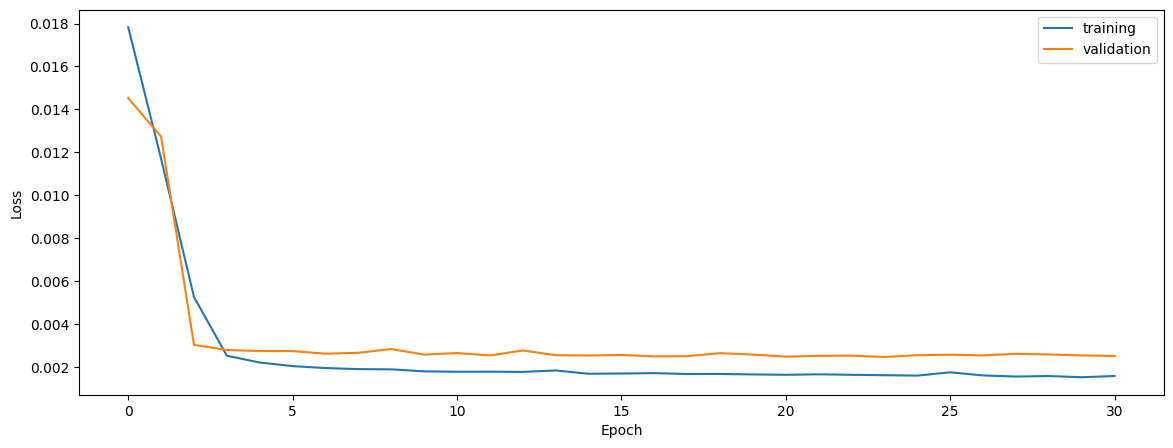

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9326291799677145
0.9110215736005378
0.9393670257496541


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9326291799677145
0.9110215736005378
0.9393670257496541


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9351645432641132
0.9119641558198732
0.9484694829989722


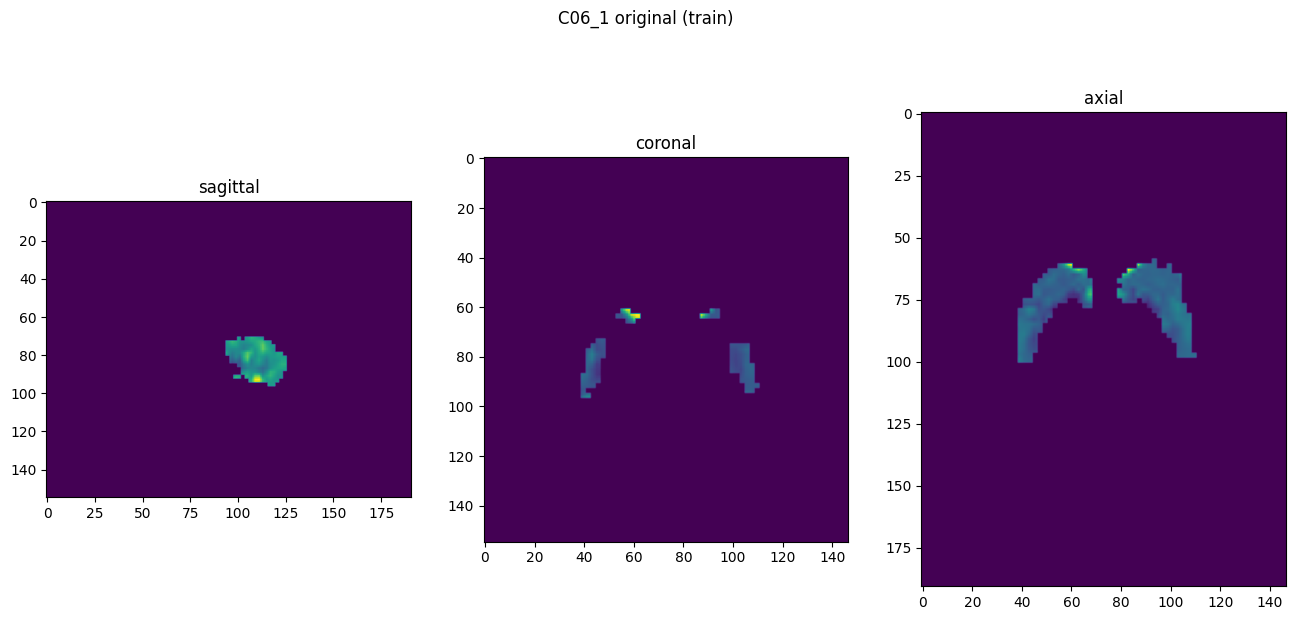

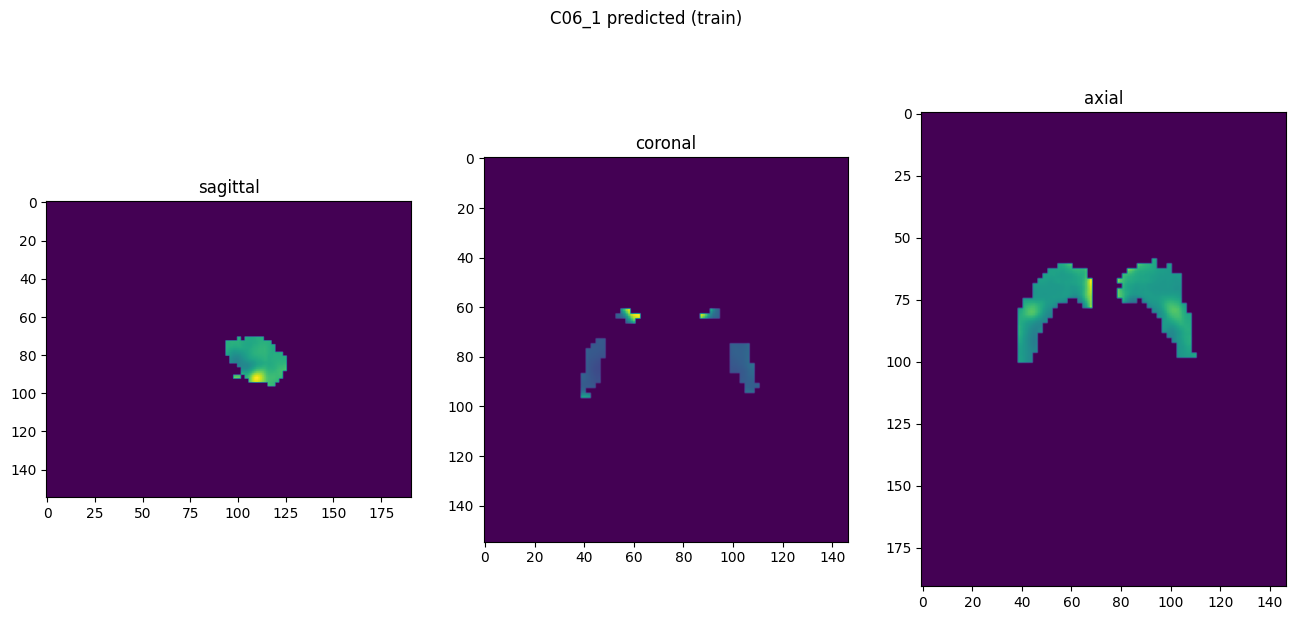

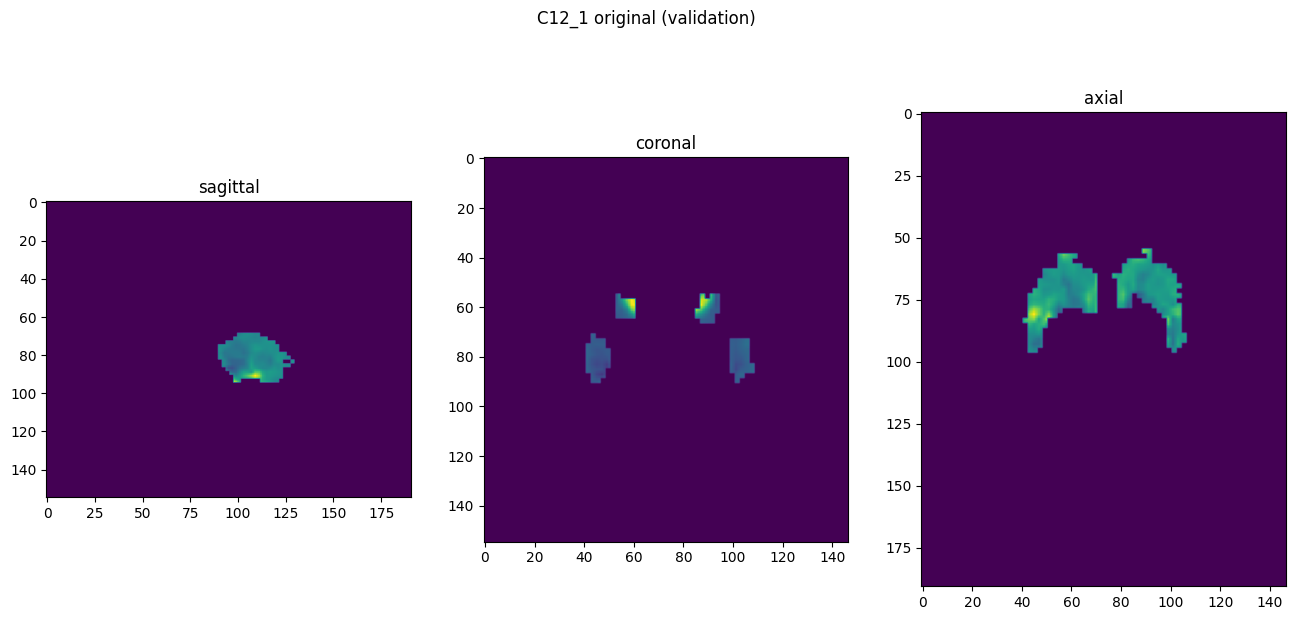

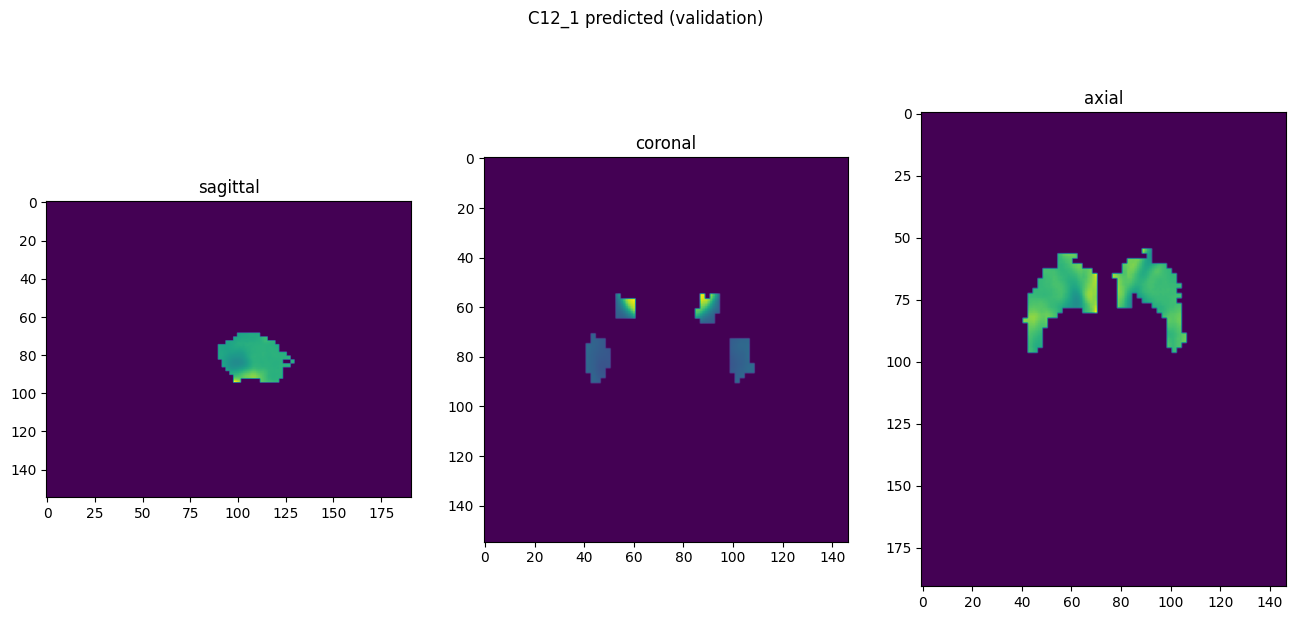

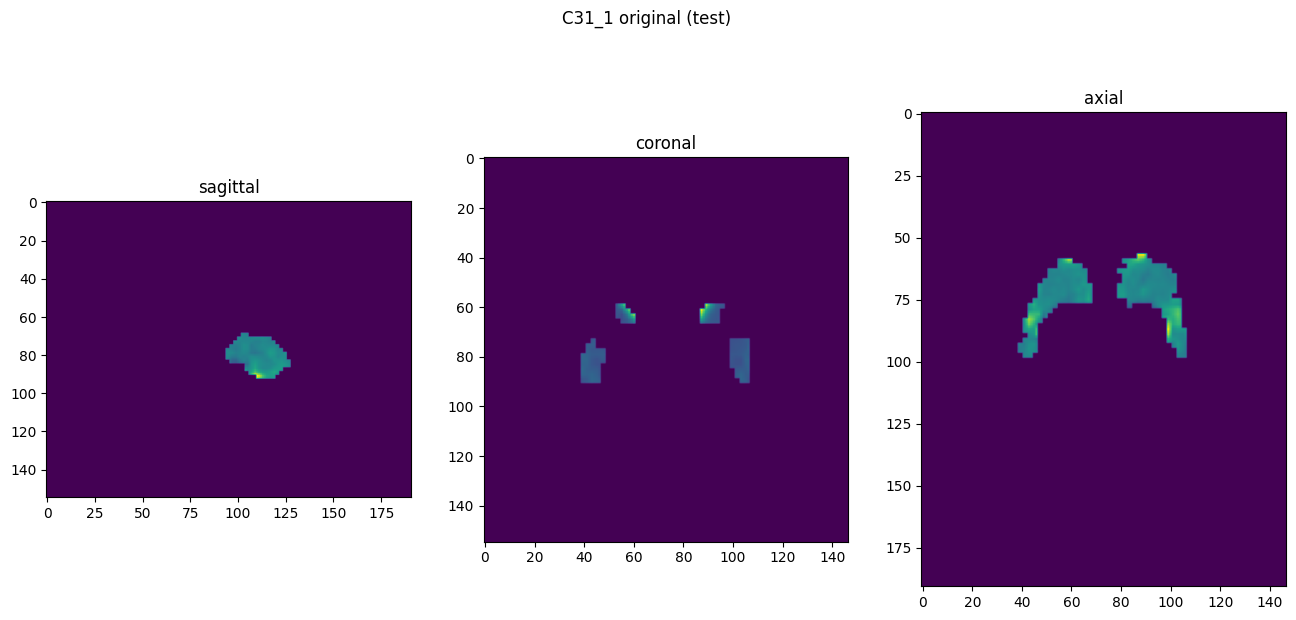

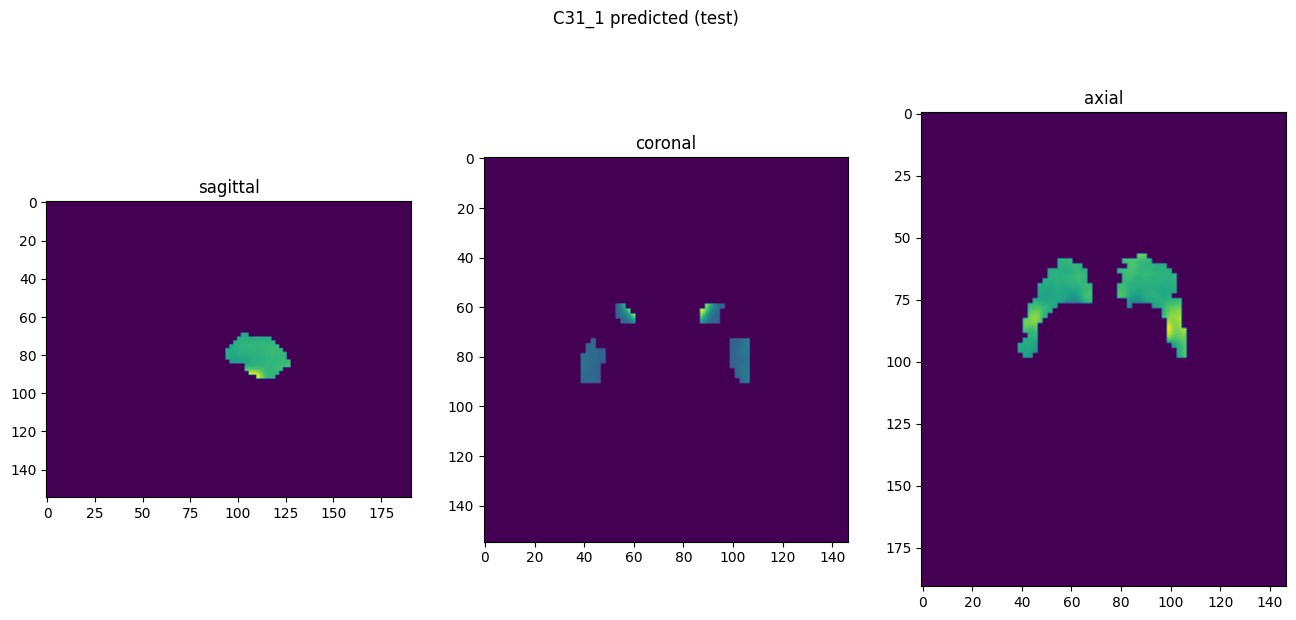

In [10]:
showResults(model, gen, threshold=None, background=False)